**Description**:

This Notebook focuses implementing K-Means on PCA, TSNE, and UMAP data. Once we cluster and label the data we export it as an excel file to analyze the custers on a different notebook

## Imports

In [4]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Non-Hierarchical Clustering Models
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
import umap
from sklearn.manifold import TSNE

# Hierarchical Clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

# Metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

c:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
%pip install kmodes scikit-learn-extra 



[notice] A new release of pip is available: 23.3.2 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
path = '../datasets/FoodInsecurity_Hispanic_Demographics_Tone_Preferences_Dataset.xlsx'

In [6]:
df = pd.read_excel(path)

In [7]:
demographics = df[['age', 'gender', 'ethnicity', 'race', 'education', 'marital_status', 'income', 'employment', 'language', 'disability', 'states']]

## Pre-processing

### Encoding

In [8]:
demographics_encoded = pd.get_dummies(demographics)

### Scaling Data

In [9]:
scaler = StandardScaler()
demographics_scaled = scaler.fit_transform(demographics_encoded)

In [10]:
# demographics_encoded.to_excel('demographics_encoded.xlsx', index=False)

## Agglomerative clustering

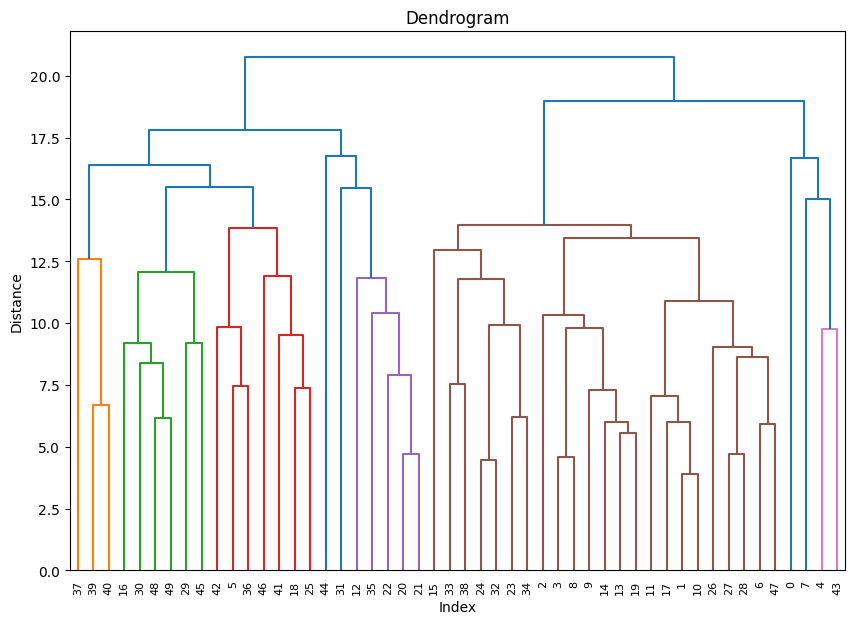

In [11]:
agg_clustering = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')

clusters = agg_clustering.fit_predict(demographics_scaled)
linked = linkage(demographics_scaled, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, labels=df.index, distance_sort='ascending')
plt.title('Dendrogram')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()

In [12]:
# Calculate cophenetic correlation coefficient
c, coph_dists = cophenet(linked, pdist(demographics_scaled))
print(f"Cophenetic Correlation Coefficient: {c}")


Cophenetic Correlation Coefficient: 0.4826501064852144


In [13]:
agg_df = demographics.copy()

In [14]:
agg_df['Cluster'] = clusters

In [16]:
agg_choices = demographics.copy()
agg_choices['Cluster'] = clusters

In [18]:
X = demographics_scaled

# Define parameters to tune
linkage_methods = ['ward', 'complete', 'average', 'single']
affinity_metrics = ['euclidean', 'manhattan', 'cosine']
n_clusters_range = range(2, 50)  # Adjust based on your dataset and requirements

# Lists to store results
best_silhouette_score = -1
best_params = {}


# Perform parameter tuning
for linkage in linkage_methods:
    for affinity in affinity_metrics:
        # Skip combinations that are incompatible
        if (linkage == 'ward' and affinity != 'euclidean'):
            continue
        
        for n_clusters in n_clusters_range:
            model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, metric=affinity)
            cluster_labels = model.fit_predict(X)
            silhouette_avg = silhouette_score(X, cluster_labels)
            
            # Track the best parameters based on silhouette score
            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_params = {'linkage': linkage, 'affinity': affinity, 'n_clusters': n_clusters}

# Output the best parameters found
print(f"Best Parameters: {best_params}")
print(f"Best Silhouette Score: {best_silhouette_score}")

Best Parameters: {'linkage': 'complete', 'affinity': 'euclidean', 'n_clusters': 2}
Best Silhouette Score: 0.29246377023639036


## K-Modes

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4, cost: 408.0
Run 1, iteration: 2/100, moves: 0, cost: 408.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 13, cost: 412.0
Run 2, iteration: 2/100, moves: 3, cost: 410.0
Run 2, iteration: 3/100, moves: 0, cost: 410.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 4, cost: 412.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 6, cost: 408.0
Run 4, iteration: 2/100, moves: 1, cost: 408.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 6, cost: 410.0
Run 5, iteration: 2/100, moves: 3, cost: 410.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, mo

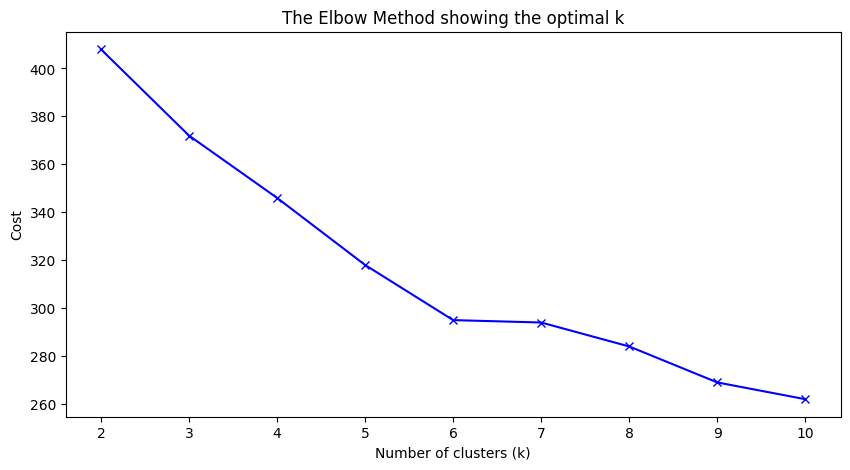

In [20]:
# Elbow method and silhouette scores for KModes
cost = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmodes = KModes(n_clusters=k, init='Huang', n_init=5, verbose=1, random_state=42)
    clusters = kmodes.fit_predict(demographics_encoded)
    cost.append(kmodes.cost_)

# Plot the Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(K, cost, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Cost')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [21]:
# Create an instance of KMeans with the desired number of clusters
kmeans = KMeans(n_clusters=6, random_state=42, n_init=50, max_iter=500)

# Fit the KMeans model to the demographics_encoded dataset
kmeans.fit(demographics_encoded)

KMeans(max_iter=500, n_clusters=6, n_init=50, random_state=42)

## PCA

In [22]:
pca = PCA(n_components=2)
demographics_pca = pca.fit_transform(demographics_encoded)

# Access the principal components
principal_components = pca.components_

# Access the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

### Elbow Method

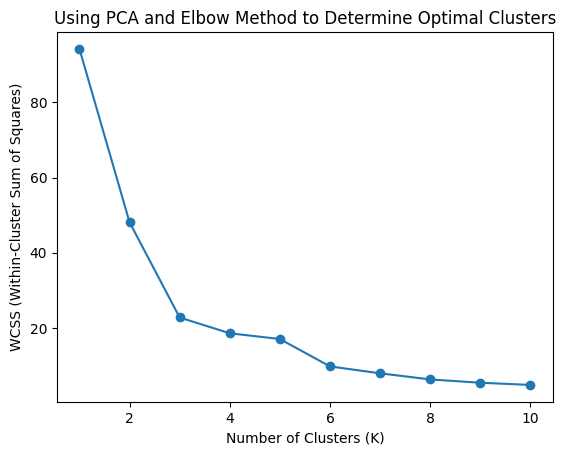

In [23]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(demographics_pca)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS

# Plotting the elbow curve
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Using PCA and Elbow Method to Determine Optimal Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

### Metrics

For n_clusters = 2, the average silhouette score is: 0.45
For n_clusters = 2, the Calinski-Harabasz index is: 46.00
For n_clusters = 2, the Davies-Bouldin score is: 0.90


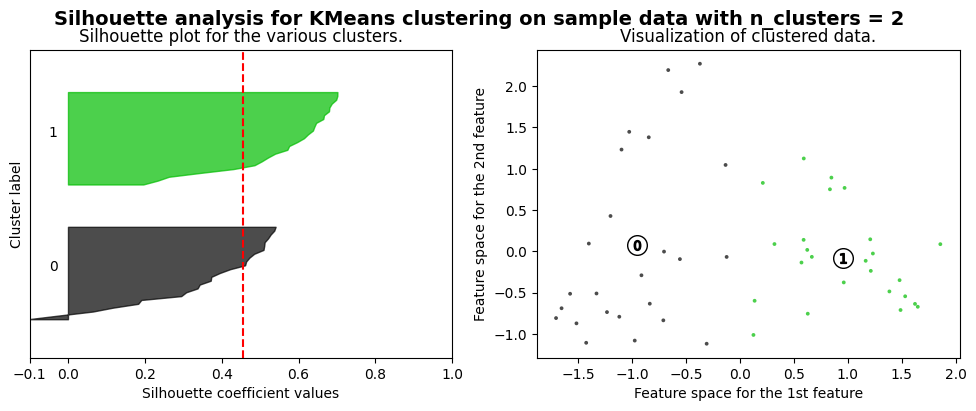

For n_clusters = 3, the average silhouette score is: 0.53
For n_clusters = 3, the Calinski-Harabasz index is: 73.66
For n_clusters = 3, the Davies-Bouldin score is: 0.60


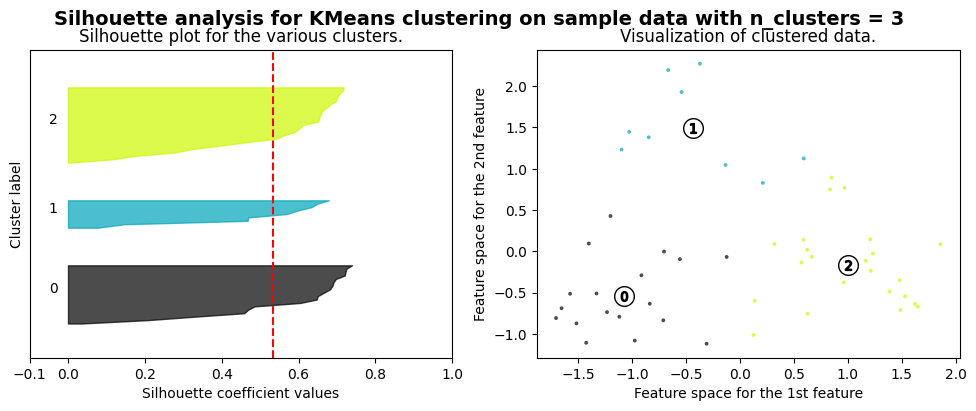

For n_clusters = 4, the average silhouette score is: 0.41
For n_clusters = 4, the Calinski-Harabasz index is: 62.40
For n_clusters = 4, the Davies-Bouldin score is: 0.82


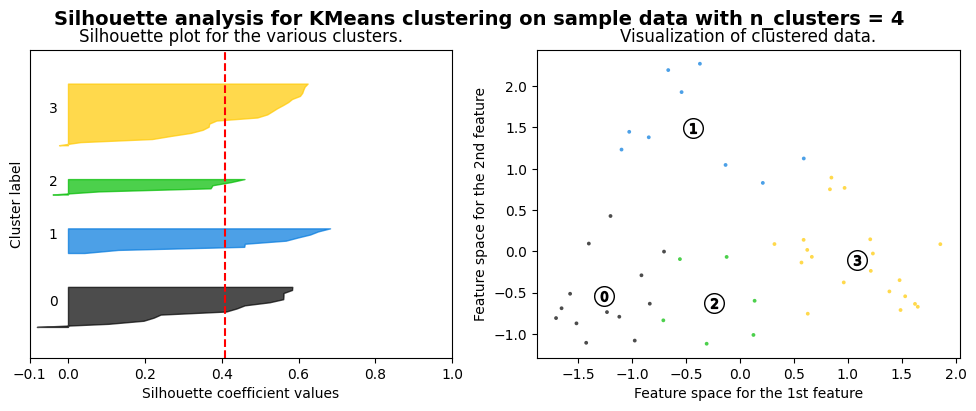

For n_clusters = 5, the average silhouette score is: 0.38
For n_clusters = 5, the Calinski-Harabasz index is: 50.87
For n_clusters = 5, the Davies-Bouldin score is: 0.89


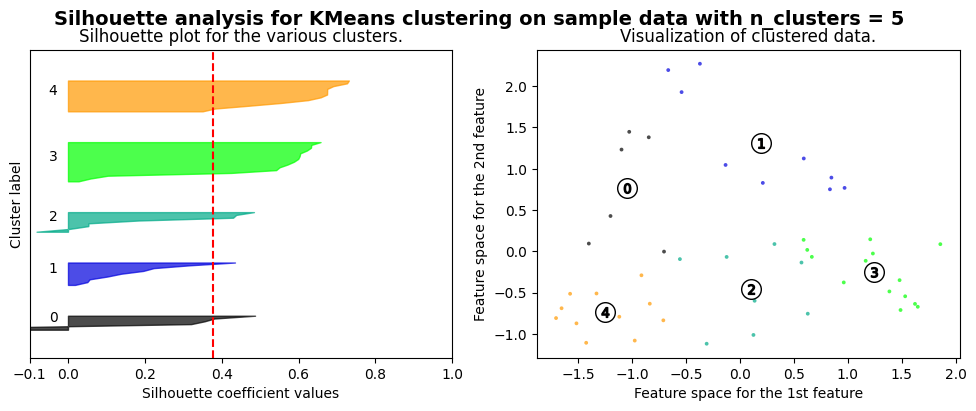

For n_clusters = 6, the average silhouette score is: 0.45
For n_clusters = 6, the Calinski-Harabasz index is: 76.03
For n_clusters = 6, the Davies-Bouldin score is: 0.75


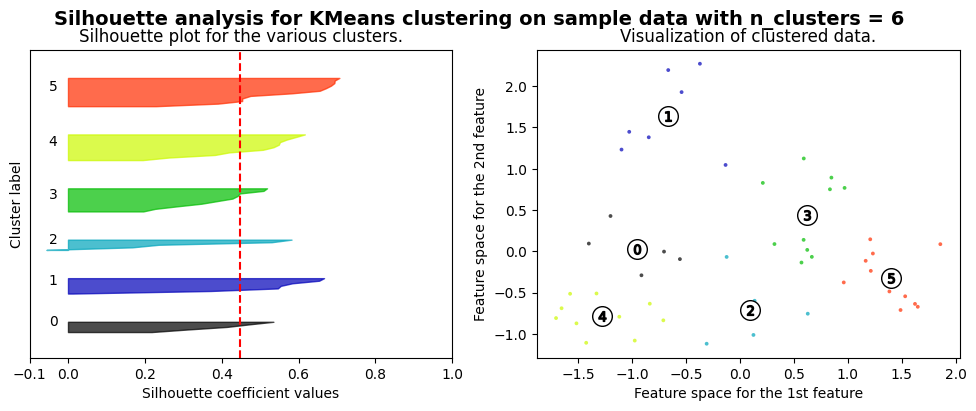

For n_clusters = 7, the average silhouette score is: 0.43
For n_clusters = 7, the Calinski-Harabasz index is: 77.88
For n_clusters = 7, the Davies-Bouldin score is: 0.74


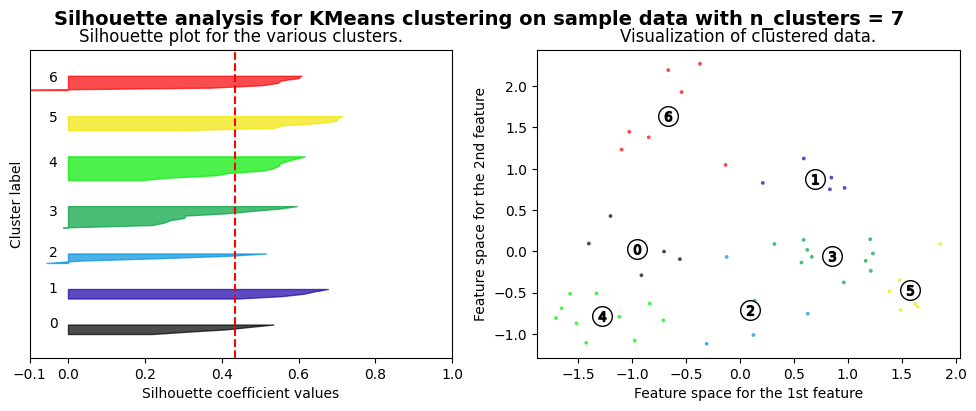

For n_clusters = 8, the average silhouette score is: 0.48
For n_clusters = 8, the Calinski-Harabasz index is: 83.55
For n_clusters = 8, the Davies-Bouldin score is: 0.68


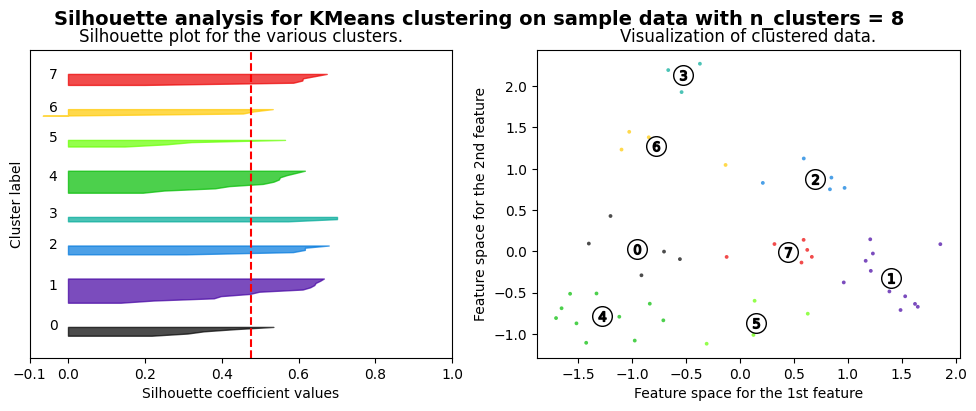

For n_clusters = 9, the average silhouette score is: 0.46
For n_clusters = 9, the Calinski-Harabasz index is: 83.78
For n_clusters = 9, the Davies-Bouldin score is: 0.67


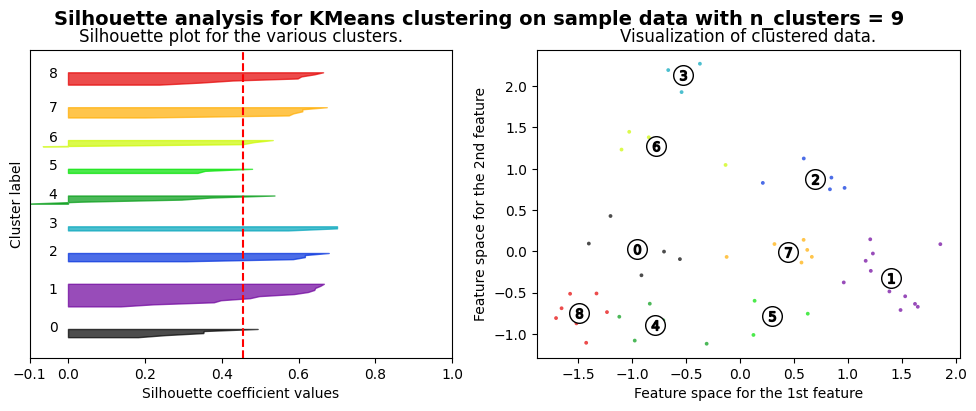

For n_clusters = 10, the average silhouette score is: 0.46
For n_clusters = 10, the Calinski-Harabasz index is: 81.89
For n_clusters = 10, the Davies-Bouldin score is: 0.65


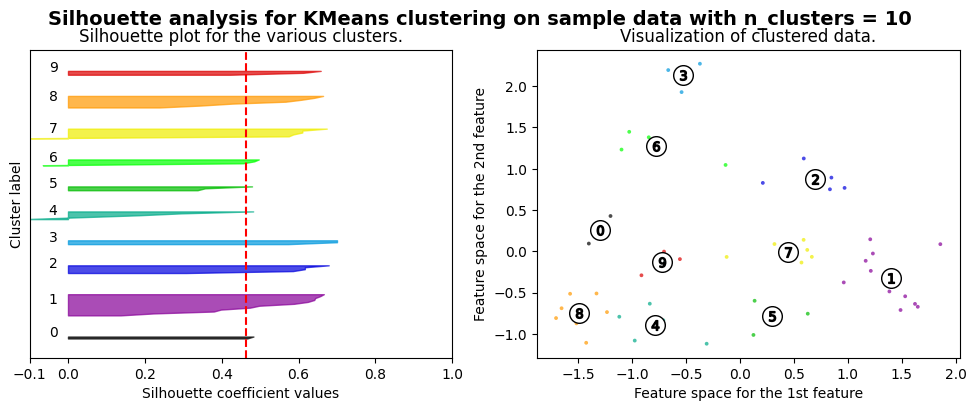

For n_clusters = 11, the average silhouette score is: 0.45
For n_clusters = 11, the Calinski-Harabasz index is: 88.67
For n_clusters = 11, the Davies-Bouldin score is: 0.67


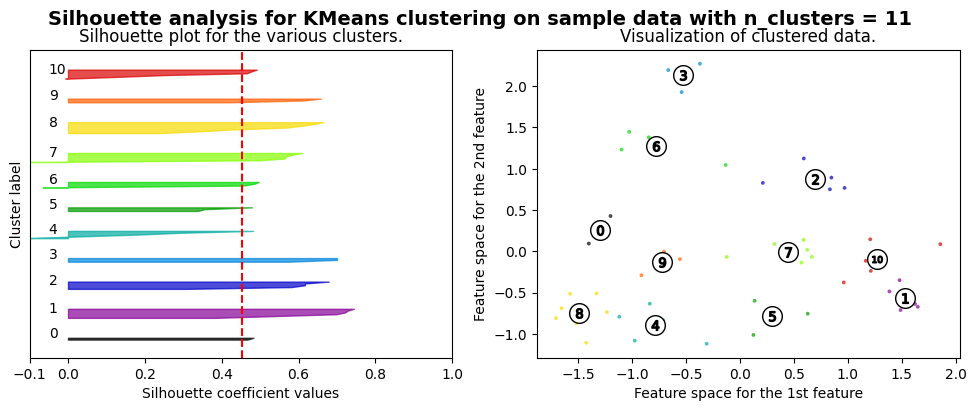

For n_clusters = 12, the average silhouette score is: 0.46
For n_clusters = 12, the Calinski-Harabasz index is: 88.93
For n_clusters = 12, the Davies-Bouldin score is: 0.60


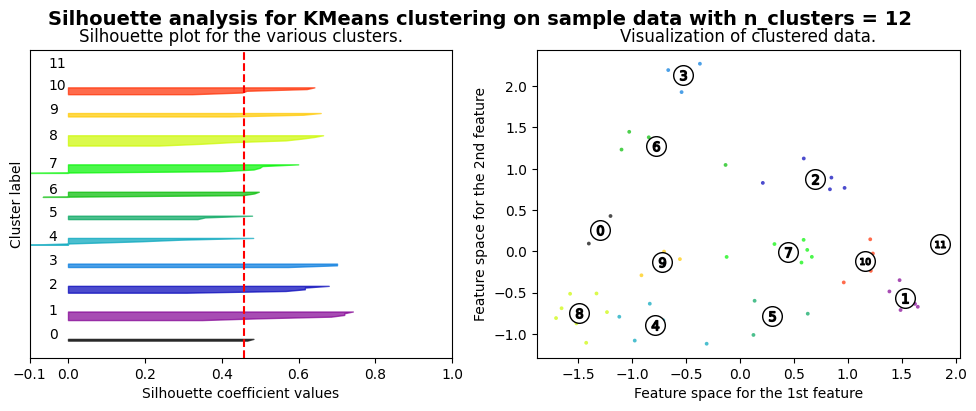

For n_clusters = 13, the average silhouette score is: 0.48
For n_clusters = 13, the Calinski-Harabasz index is: 104.67
For n_clusters = 13, the Davies-Bouldin score is: 0.55


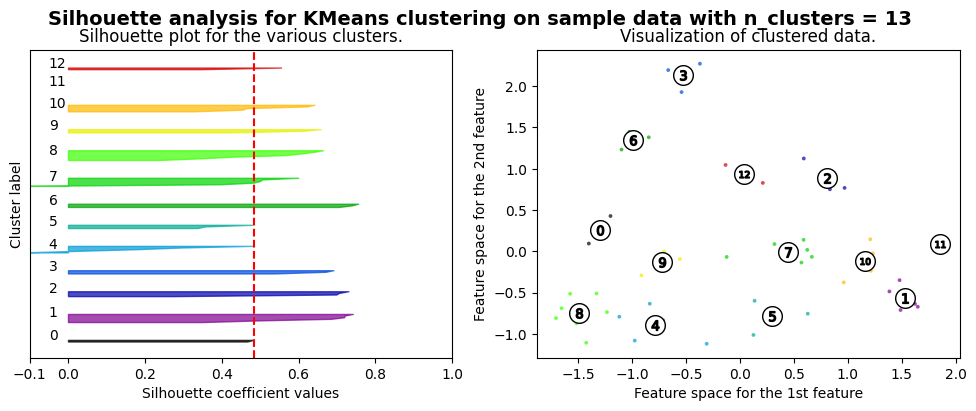

For n_clusters = 14, the average silhouette score is: 0.46
For n_clusters = 14, the Calinski-Harabasz index is: 107.98
For n_clusters = 14, the Davies-Bouldin score is: 0.54


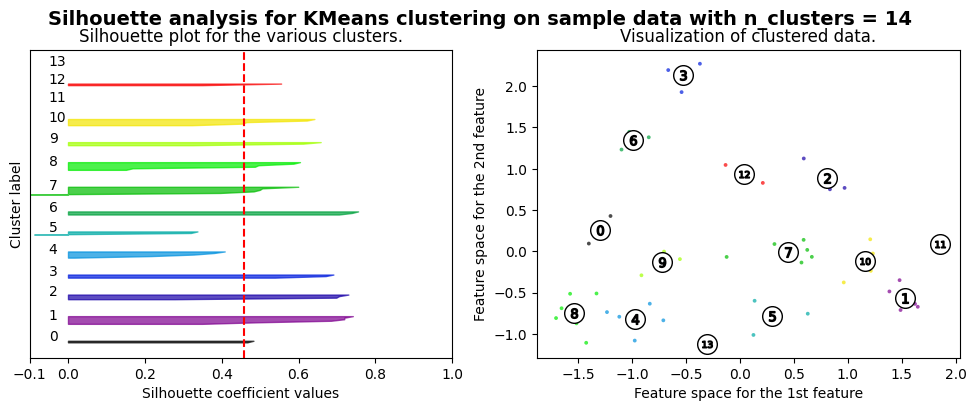

For n_clusters = 15, the average silhouette score is: 0.46
For n_clusters = 15, the Calinski-Harabasz index is: 115.12
For n_clusters = 15, the Davies-Bouldin score is: 0.54


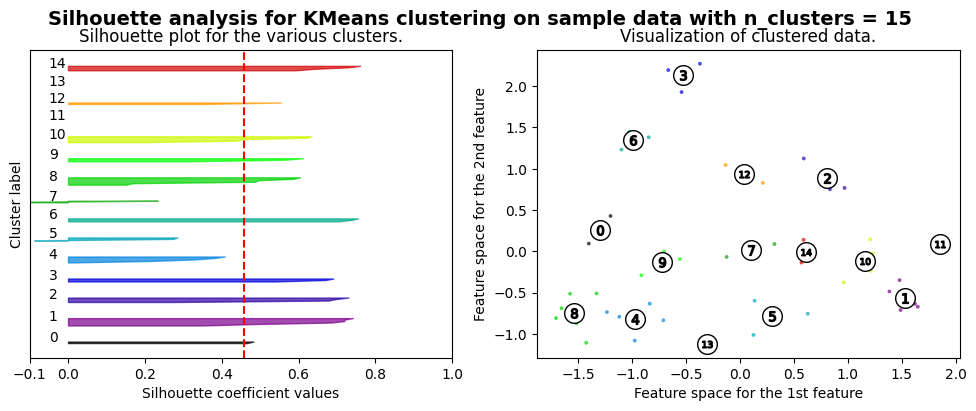

For n_clusters = 16, the average silhouette score is: 0.43
For n_clusters = 16, the Calinski-Harabasz index is: 110.23
For n_clusters = 16, the Davies-Bouldin score is: 0.57


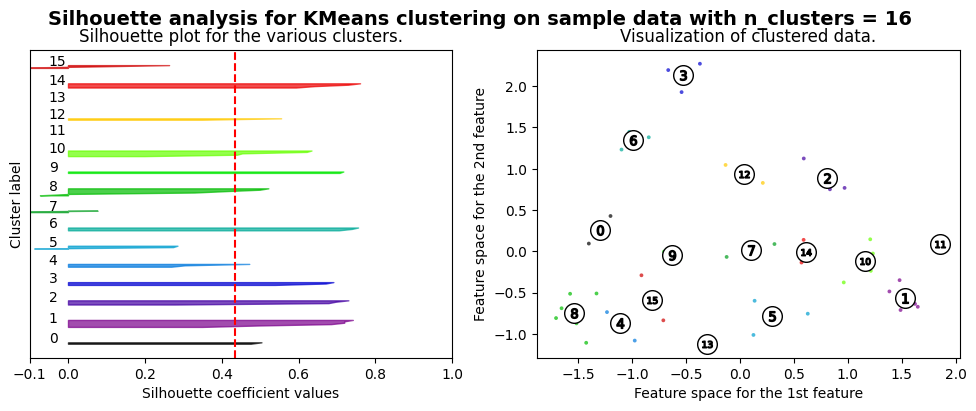

For n_clusters = 17, the average silhouette score is: 0.40
For n_clusters = 17, the Calinski-Harabasz index is: 105.55
For n_clusters = 17, the Davies-Bouldin score is: 0.58


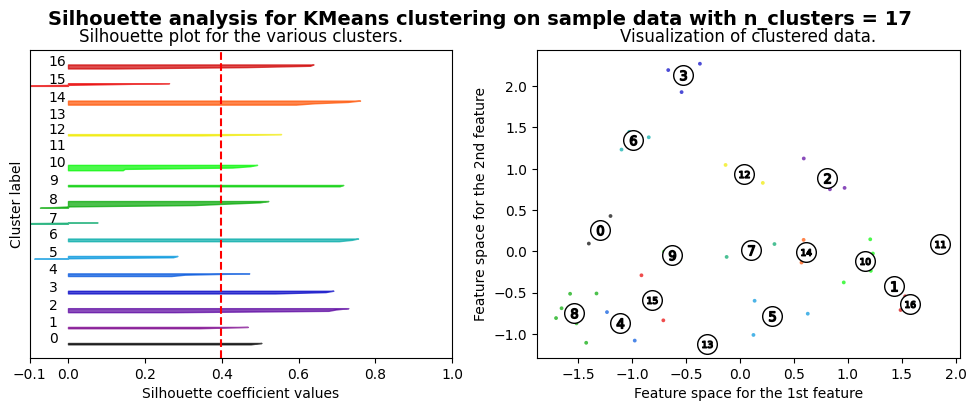

For n_clusters = 18, the average silhouette score is: 0.40
For n_clusters = 18, the Calinski-Harabasz index is: 106.35
For n_clusters = 18, the Davies-Bouldin score is: 0.57


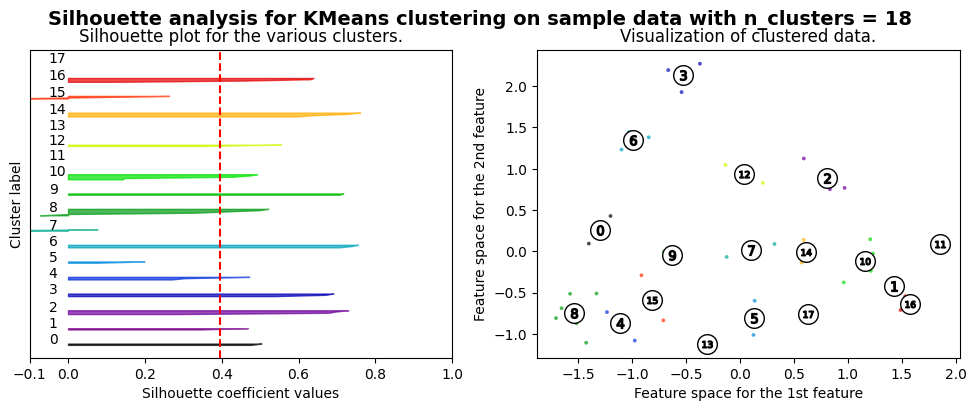

For n_clusters = 19, the average silhouette score is: 0.38
For n_clusters = 19, the Calinski-Harabasz index is: 109.09
For n_clusters = 19, the Davies-Bouldin score is: 0.59


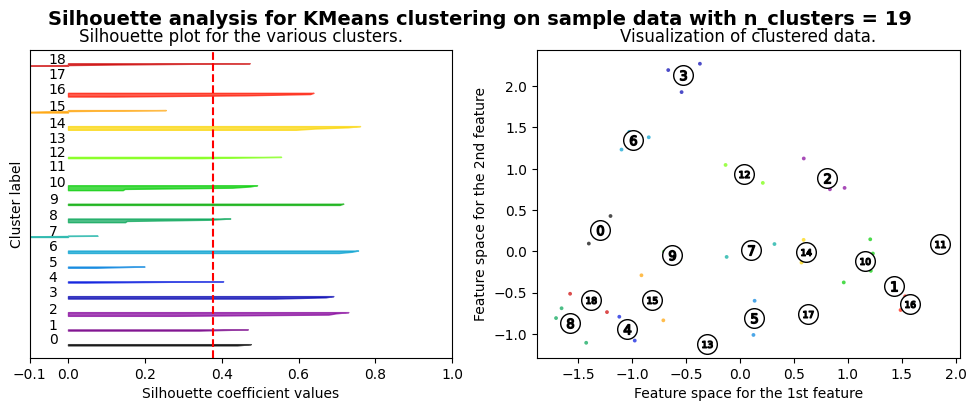

For n_clusters = 20, the average silhouette score is: 0.37
For n_clusters = 20, the Calinski-Harabasz index is: 107.89
For n_clusters = 20, the Davies-Bouldin score is: 0.57


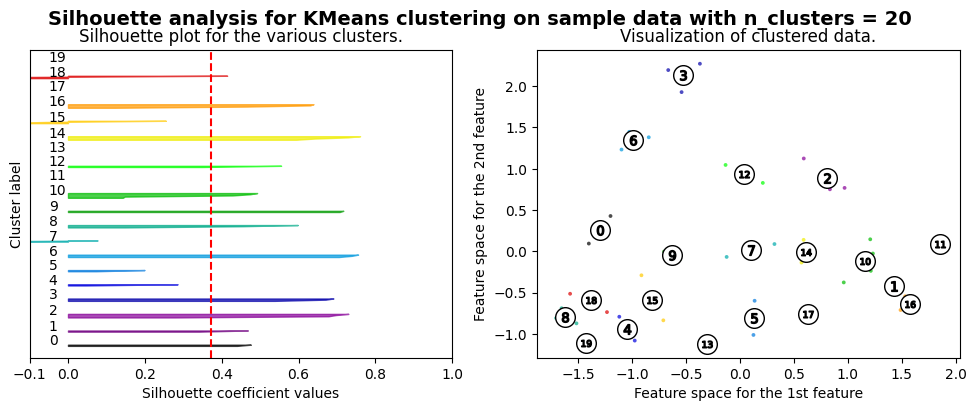

In [24]:
range_n_clusters = [2, 3, 4, 5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(demographics_pca) + (n_clusters + 1) * 10])

    # Initialize the KMeans object and fit it to the data
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(demographics_pca)

    # Compute the silhouette score for the current clustering
    silhouette_avg = silhouette_score(demographics_pca, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is: {silhouette_avg:.2f}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(demographics_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("Silhouette plot for the various clusters.")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(demographics_pca[:, 0], demographics_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = kmeans.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("Visualization of clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    # Compute and print the Calinski-Harabasz index and Davies-Bouldin score
    calinski_harabasz = calinski_harabasz_score(demographics_pca, cluster_labels)
    davies_bouldin = davies_bouldin_score(demographics_pca, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the Calinski-Harabasz index is: {calinski_harabasz:.2f}")
    print(f"For n_clusters = {n_clusters}, the Davies-Bouldin score is: {davies_bouldin:.2f}")

    plt.show()

### Initialization

In [13]:
# Create an instance of the KMeans model
kmeans = KMeans(n_clusters=8, n_init='auto')
cluster_labels_pca = kmeans.fit_predict(demographics_pca)
# look at correlation between people and tone preferences

### Data Points in clusters

In [14]:
unique, counts = np.unique(cluster_labels_pca, return_counts=True)
cluster_sizes = dict(zip(unique, counts))

print("Cluster Sizes:", cluster_sizes)

Cluster Sizes: {0: 7, 1: 8, 2: 5, 3: 6, 4: 5, 5: 6, 6: 3, 7: 10}


### Visualizing Clusters

In [15]:
pca_df = demographics.copy()

In [16]:
pca_df['Cluster'] = cluster_labels_pca

In [38]:
pca_df.to_excel('../datasets/pca-dem-clusters.xlsx', index=False)

## T-SNE Dimensionality Reduction

In [18]:
tsne = TSNE(n_components=2)  # Reduce to 2 dimensions
X_tsne = tsne.fit_transform(demographics_encoded) # type: ignore

### Elbow Method

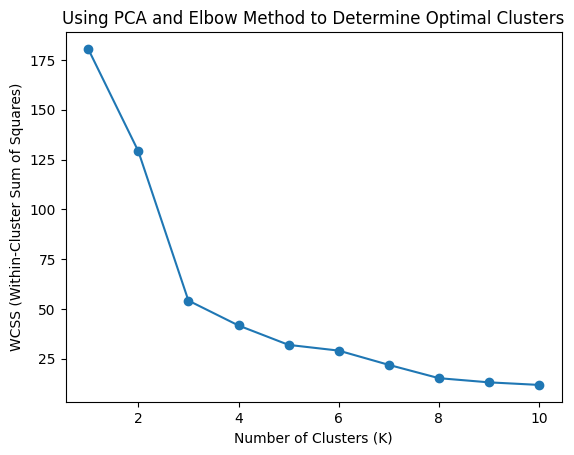

In [19]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_tsne)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS

# Plotting the elbow curve
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Using PCA and Elbow Method to Determine Optimal Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

For n_clusters = 2, the average silhouette score is: 0.28
For n_clusters = 2, the Calinski-Harabasz index is: 19.09
For n_clusters = 2, the Davies-Bouldin score is: 1.40


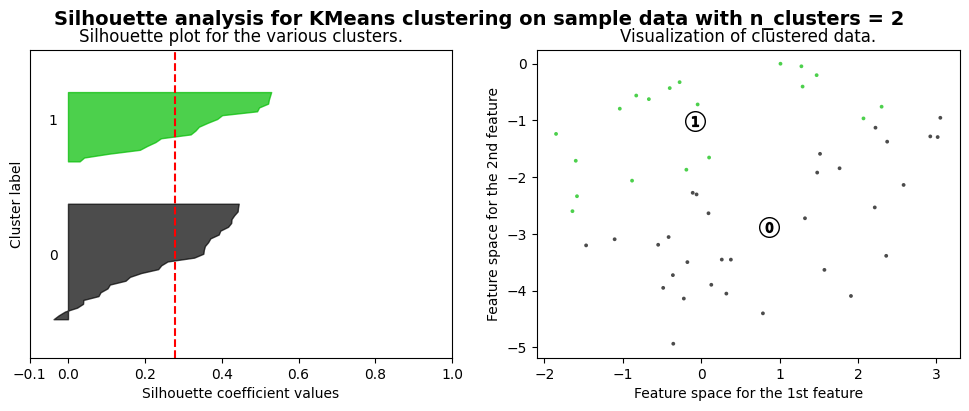

For n_clusters = 3, the average silhouette score is: 0.44
For n_clusters = 3, the Calinski-Harabasz index is: 54.88
For n_clusters = 3, the Davies-Bouldin score is: 0.77


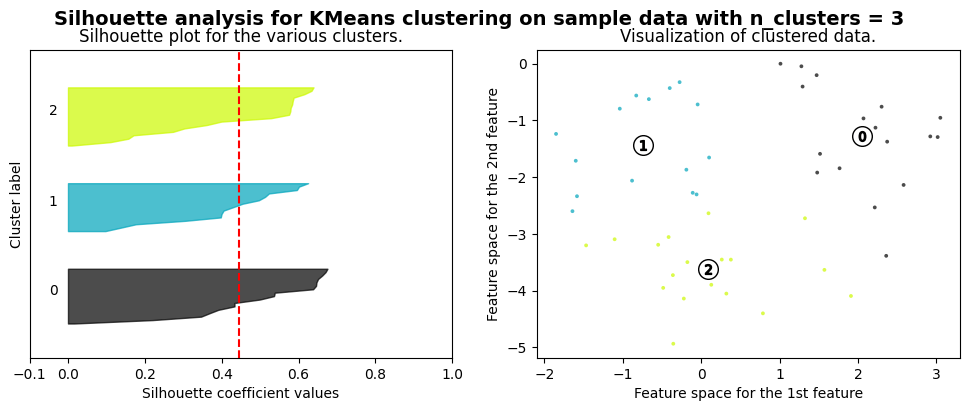

For n_clusters = 4, the average silhouette score is: 0.40
For n_clusters = 4, the Calinski-Harabasz index is: 51.17
For n_clusters = 4, the Davies-Bouldin score is: 0.81


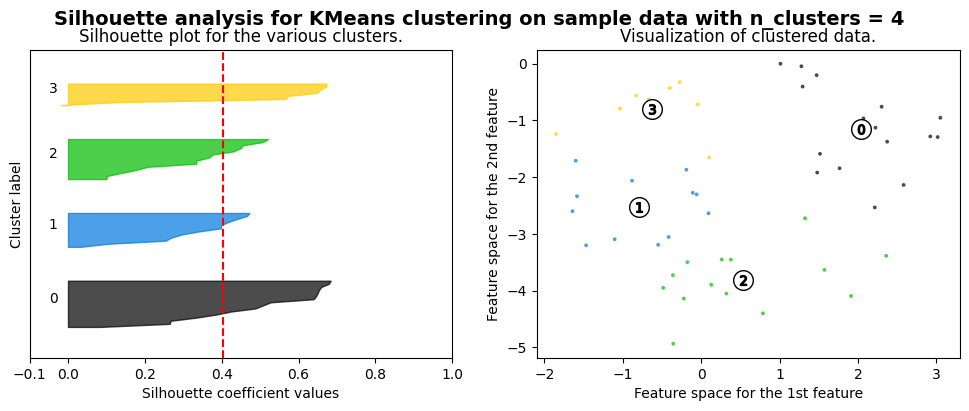

For n_clusters = 5, the average silhouette score is: 0.37
For n_clusters = 5, the Calinski-Harabasz index is: 52.47
For n_clusters = 5, the Davies-Bouldin score is: 0.86


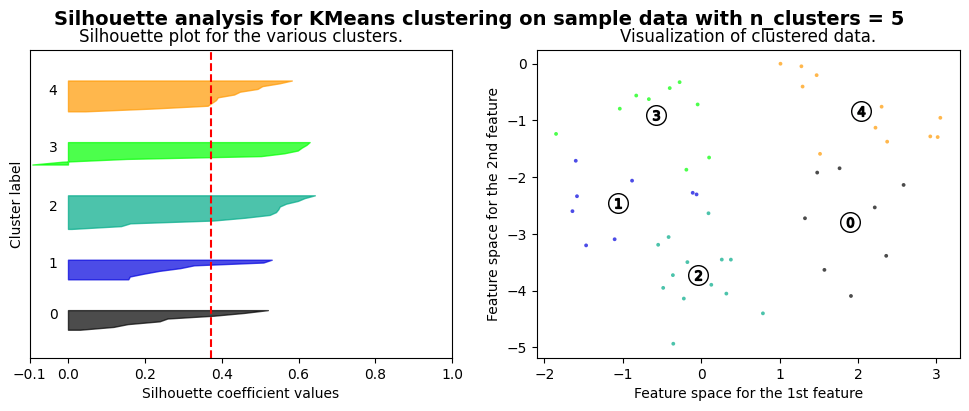

For n_clusters = 7, the average silhouette score is: 0.40
For n_clusters = 7, the Calinski-Harabasz index is: 52.07
For n_clusters = 7, the Davies-Bouldin score is: 0.75


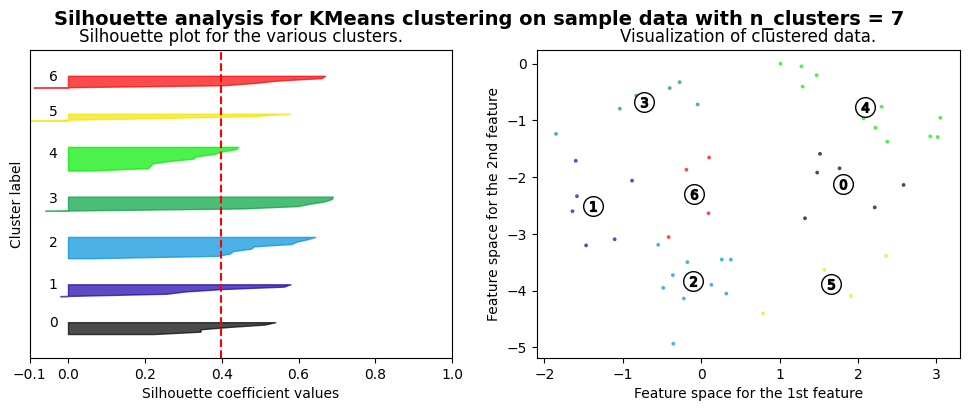

For n_clusters = 8, the average silhouette score is: 0.47
For n_clusters = 8, the Calinski-Harabasz index is: 65.46
For n_clusters = 8, the Davies-Bouldin score is: 0.65


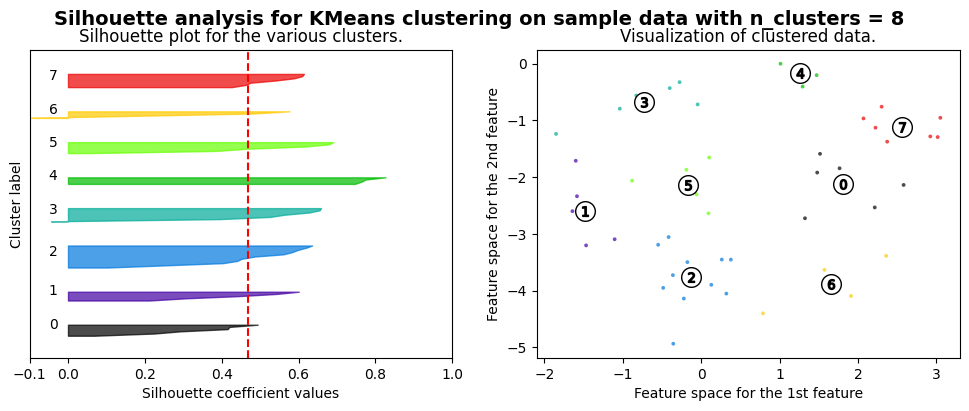

For n_clusters = 9, the average silhouette score is: 0.41
For n_clusters = 9, the Calinski-Harabasz index is: 65.70
For n_clusters = 9, the Davies-Bouldin score is: 0.77


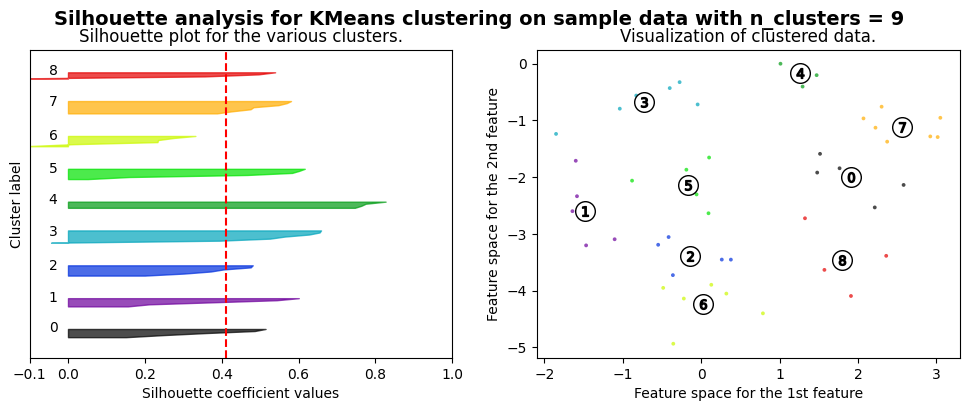

For n_clusters = 10, the average silhouette score is: 0.42
For n_clusters = 10, the Calinski-Harabasz index is: 63.73
For n_clusters = 10, the Davies-Bouldin score is: 0.70


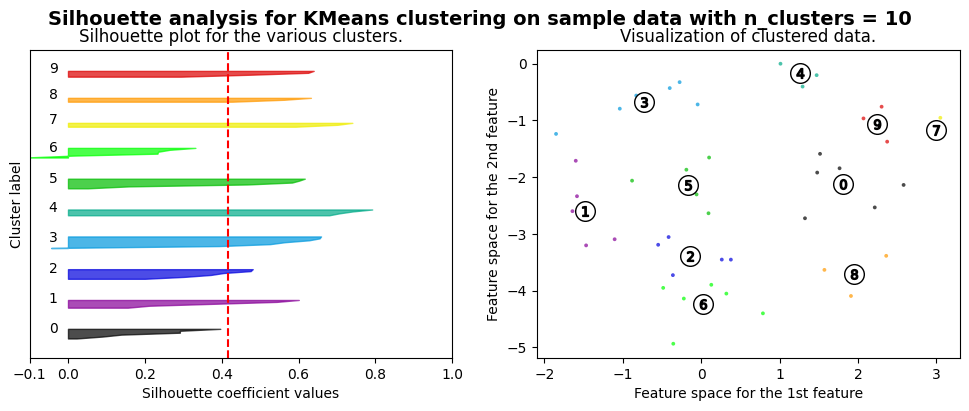

For n_clusters = 11, the average silhouette score is: 0.42
For n_clusters = 11, the Calinski-Harabasz index is: 71.32
For n_clusters = 11, the Davies-Bouldin score is: 0.68


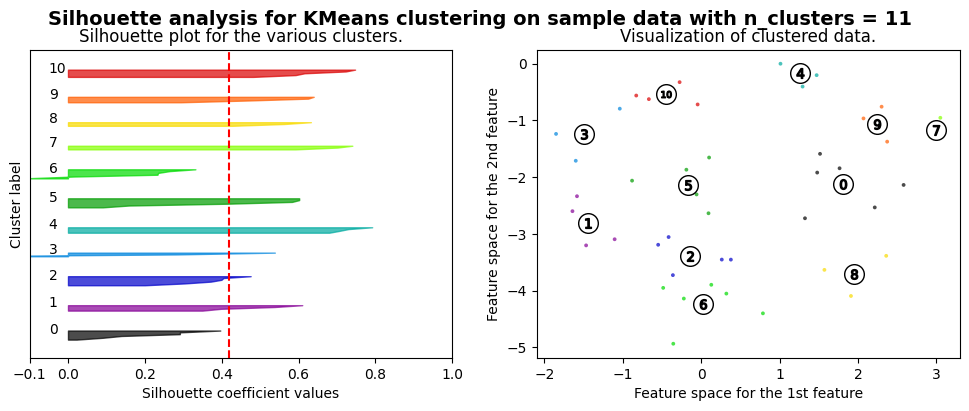

For n_clusters = 12, the average silhouette score is: 0.41
For n_clusters = 12, the Calinski-Harabasz index is: 69.21
For n_clusters = 12, the Davies-Bouldin score is: 0.66


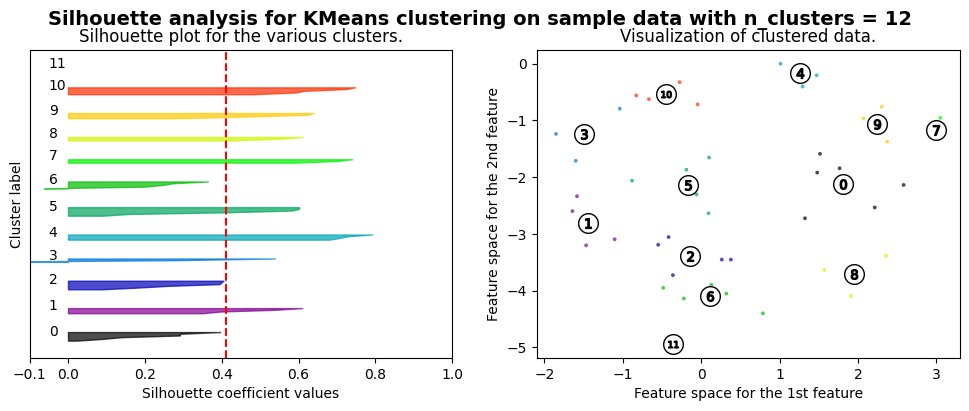

For n_clusters = 13, the average silhouette score is: 0.42
For n_clusters = 13, the Calinski-Harabasz index is: 68.75
For n_clusters = 13, the Davies-Bouldin score is: 0.60


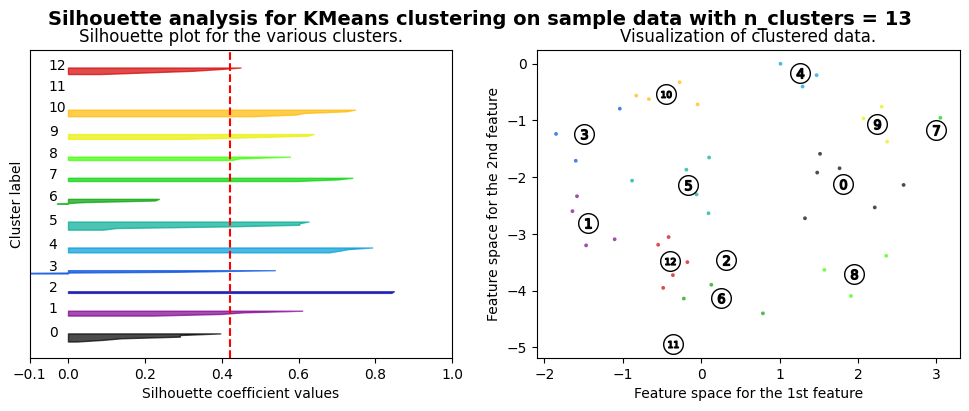

For n_clusters = 14, the average silhouette score is: 0.44
For n_clusters = 14, the Calinski-Harabasz index is: 71.35
For n_clusters = 14, the Davies-Bouldin score is: 0.63


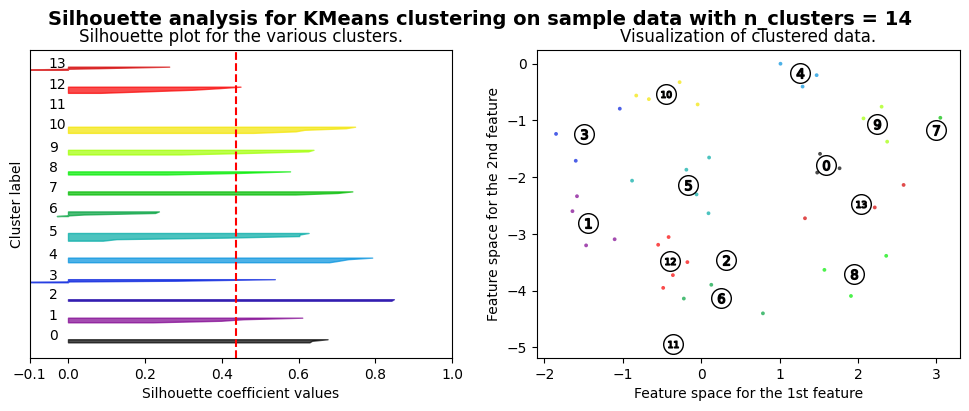

For n_clusters = 15, the average silhouette score is: 0.43
For n_clusters = 15, the Calinski-Harabasz index is: 72.99
For n_clusters = 15, the Davies-Bouldin score is: 0.65


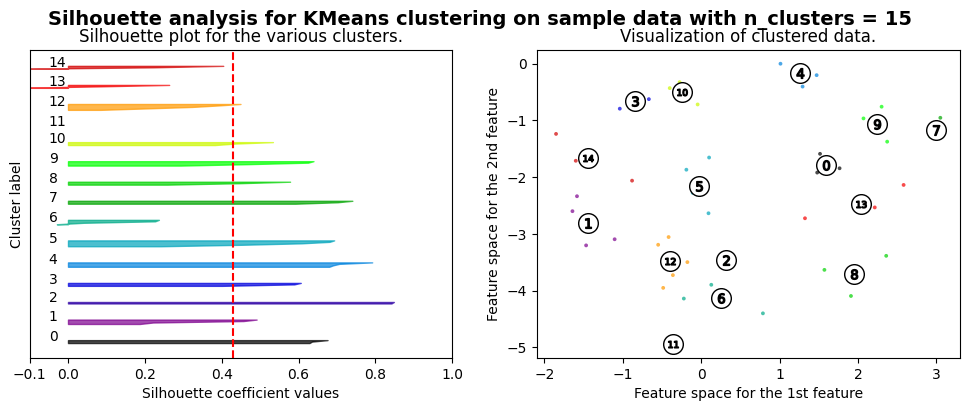

For n_clusters = 16, the average silhouette score is: 0.43
For n_clusters = 16, the Calinski-Harabasz index is: 74.32
For n_clusters = 16, the Davies-Bouldin score is: 0.65


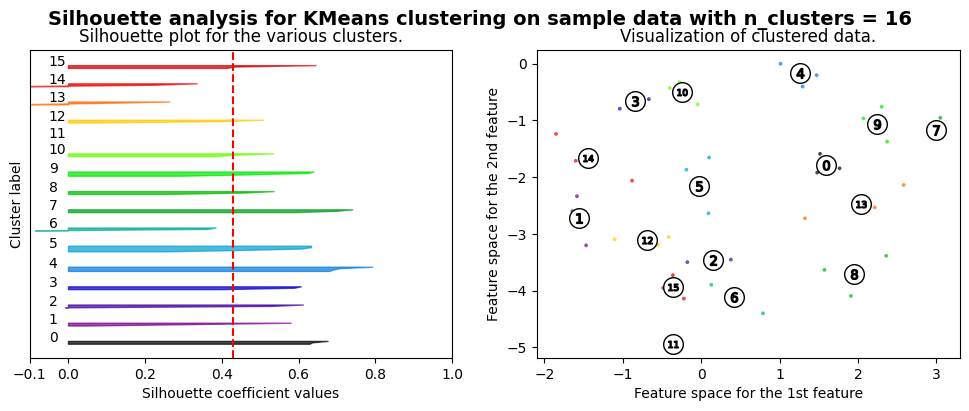

For n_clusters = 17, the average silhouette score is: 0.45
For n_clusters = 17, the Calinski-Harabasz index is: 75.78
For n_clusters = 17, the Davies-Bouldin score is: 0.62


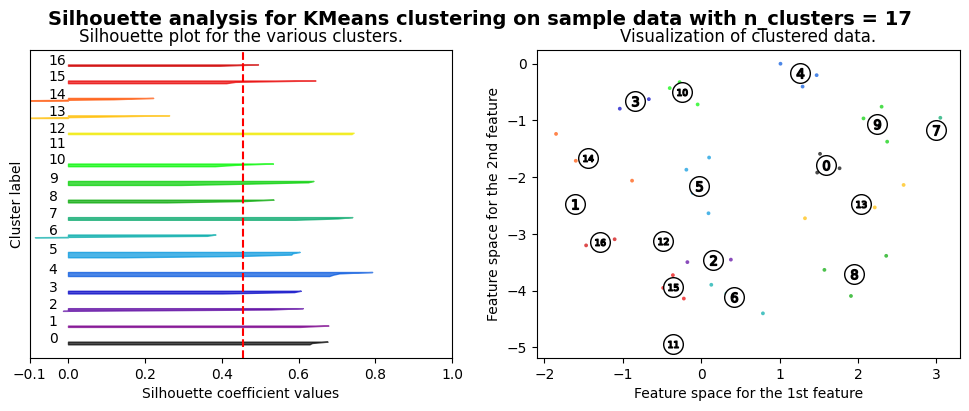

For n_clusters = 18, the average silhouette score is: 0.46
For n_clusters = 18, the Calinski-Harabasz index is: 84.97
For n_clusters = 18, the Davies-Bouldin score is: 0.54


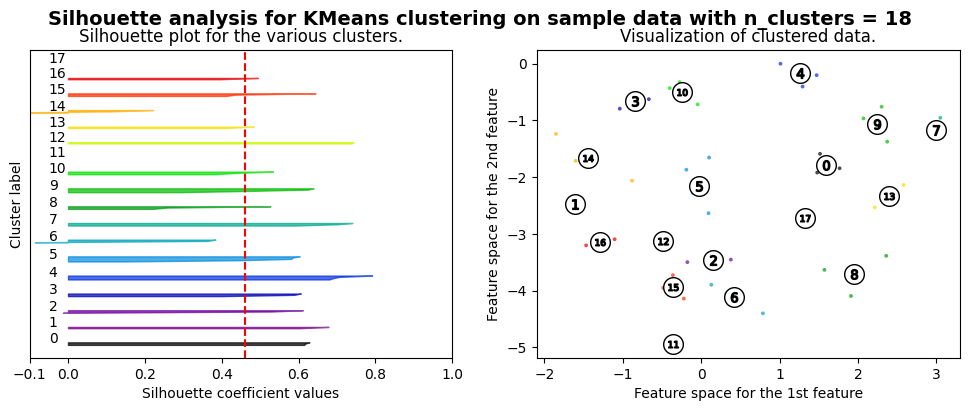

For n_clusters = 19, the average silhouette score is: 0.44
For n_clusters = 19, the Calinski-Harabasz index is: 81.23
For n_clusters = 19, the Davies-Bouldin score is: 0.56


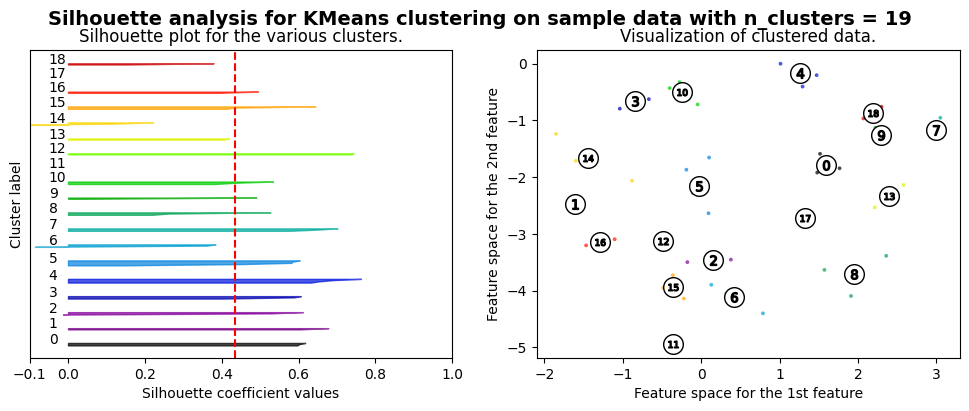

For n_clusters = 20, the average silhouette score is: 0.43
For n_clusters = 20, the Calinski-Harabasz index is: 83.75
For n_clusters = 20, the Davies-Bouldin score is: 0.54


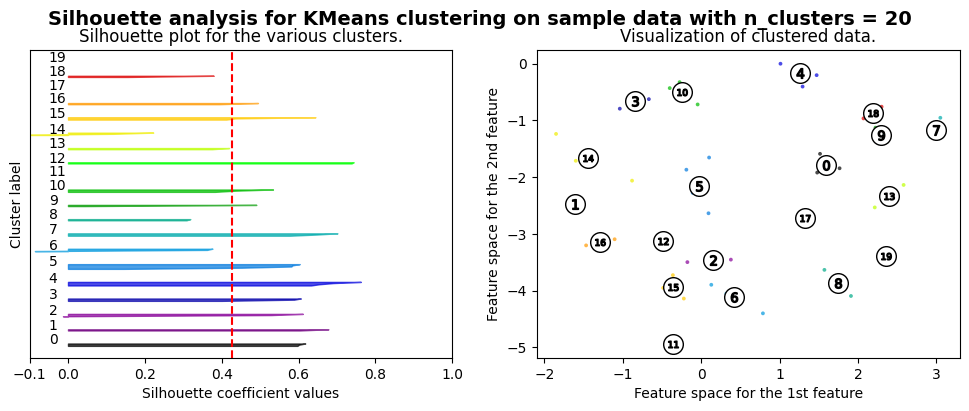

In [20]:
range_n_clusters = [2, 3, 4, 5,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_tsne) + (n_clusters + 1) * 10])

    # Initialize the KMeans object and fit it to the data
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(X_tsne)

    # Compute the silhouette score for the current clustering
    silhouette_avg = silhouette_score(X_tsne, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is: {silhouette_avg:.2f}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_tsne, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("Silhouette plot for the various clusters.")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = kmeans.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("Visualization of clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    # Compute and print the Calinski-Harabasz index and Davies-Bouldin score
    calinski_harabasz = calinski_harabasz_score(X_tsne, cluster_labels)
    davies_bouldin = davies_bouldin_score(X_tsne, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the Calinski-Harabasz index is: {calinski_harabasz:.2f}")
    print(f"For n_clusters = {n_clusters}, the Davies-Bouldin score is: {davies_bouldin:.2f}")

    plt.show()

### Data Points in Clusters

In [25]:
kmeans = KMeans(n_clusters=8, random_state=42, n_init='auto')
cluster_labels_tsne = kmeans.fit_predict(X_tsne)

### Visualing Clusters

In [28]:
tsne_df = demographics.copy()

In [29]:
tsne_df['Cluster'] = cluster_labels_tsne

In [31]:
# tsne_df.to_excel('../datasets/tsne-dem-clusters.xlsx', index=False)

## UMAP

In [32]:
umap_model = umap.UMAP(n_components=2)  # Reduce to 2 dimensions
X_umap = umap_model.fit_transform(demographics_encoded)

For n_clusters = 2, the average silhouette score is: 0.51
For n_clusters = 2, the Calinski-Harabasz index is: 69.40
For n_clusters = 2, the Davies-Bouldin score is: 0.72


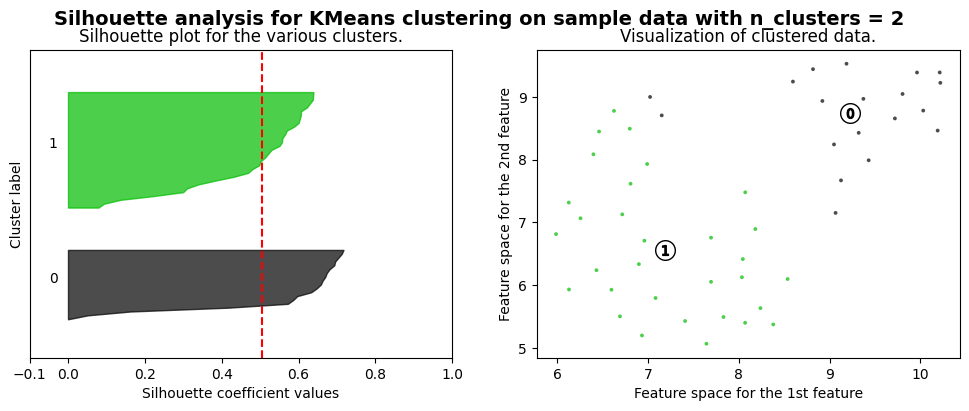

For n_clusters = 3, the average silhouette score is: 0.52
For n_clusters = 3, the Calinski-Harabasz index is: 90.71
For n_clusters = 3, the Davies-Bouldin score is: 0.69


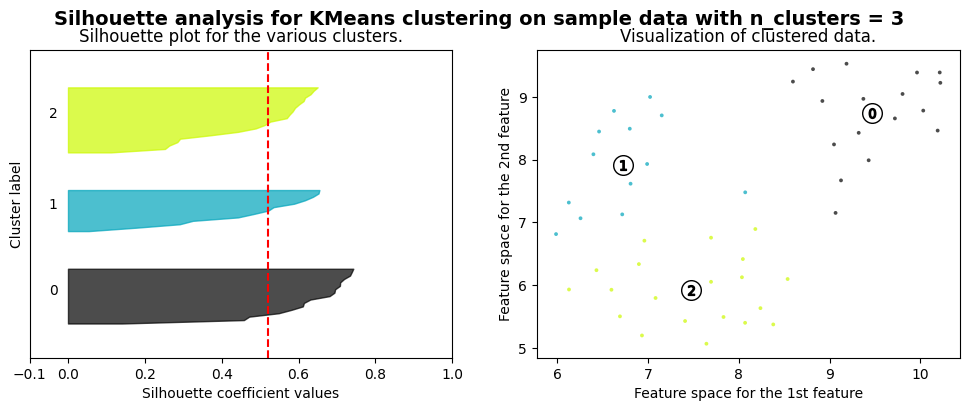

For n_clusters = 4, the average silhouette score is: 0.47
For n_clusters = 4, the Calinski-Harabasz index is: 84.21
For n_clusters = 4, the Davies-Bouldin score is: 0.73


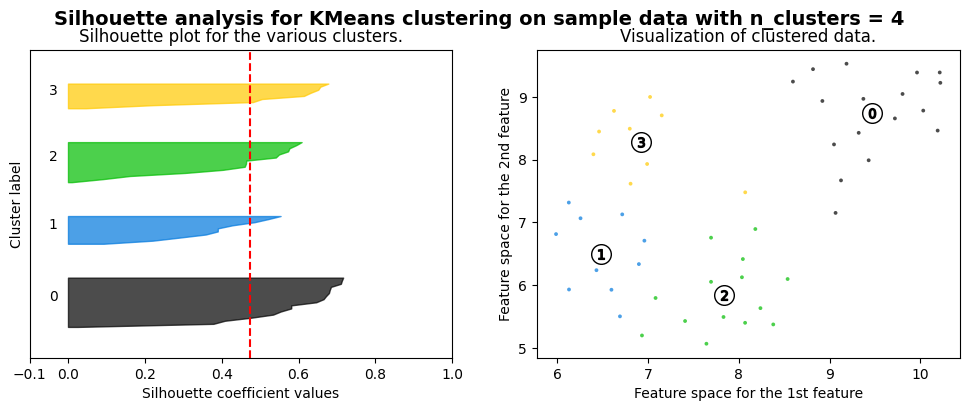

For n_clusters = 5, the average silhouette score is: 0.42
For n_clusters = 5, the Calinski-Harabasz index is: 84.75
For n_clusters = 5, the Davies-Bouldin score is: 0.79


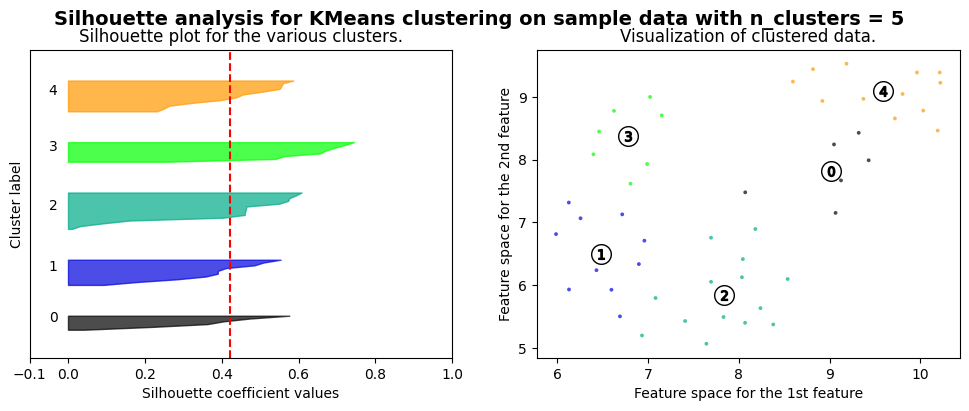

For n_clusters = 6, the average silhouette score is: 0.41
For n_clusters = 6, the Calinski-Harabasz index is: 84.83
For n_clusters = 6, the Davies-Bouldin score is: 0.77


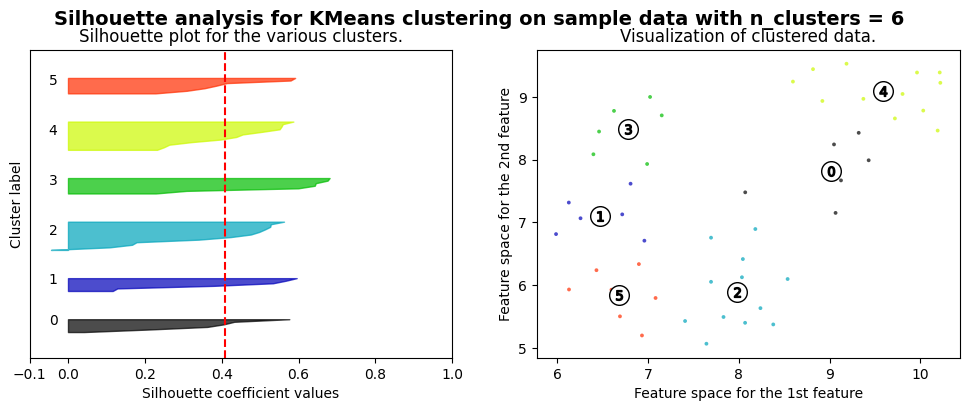

For n_clusters = 7, the average silhouette score is: 0.36
For n_clusters = 7, the Calinski-Harabasz index is: 79.02
For n_clusters = 7, the Davies-Bouldin score is: 0.80


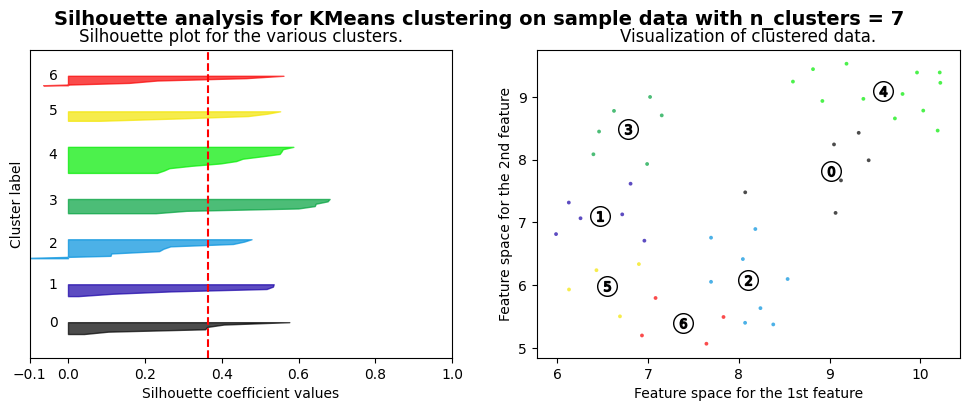

For n_clusters = 8, the average silhouette score is: 0.35
For n_clusters = 8, the Calinski-Harabasz index is: 74.80
For n_clusters = 8, the Davies-Bouldin score is: 0.79


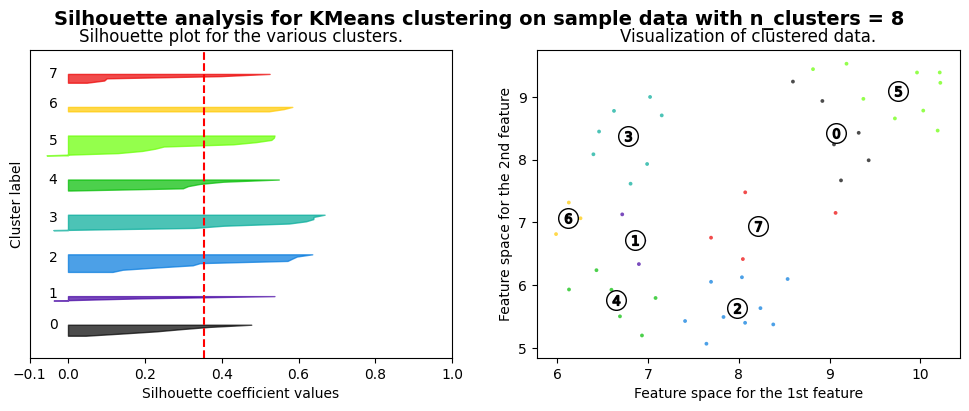

For n_clusters = 9, the average silhouette score is: 0.34
For n_clusters = 9, the Calinski-Harabasz index is: 71.00
For n_clusters = 9, the Davies-Bouldin score is: 0.82


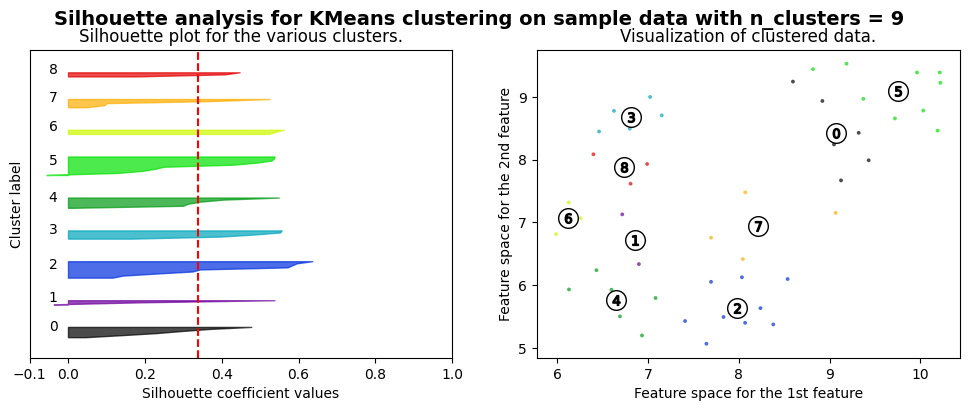

For n_clusters = 10, the average silhouette score is: 0.38
For n_clusters = 10, the Calinski-Harabasz index is: 86.00
For n_clusters = 10, the Davies-Bouldin score is: 0.70


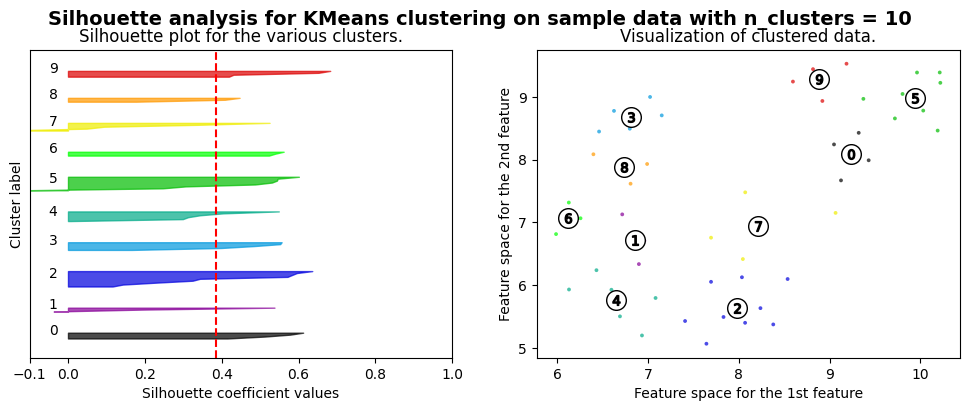

For n_clusters = 11, the average silhouette score is: 0.37
For n_clusters = 11, the Calinski-Harabasz index is: 82.89
For n_clusters = 11, the Davies-Bouldin score is: 0.72


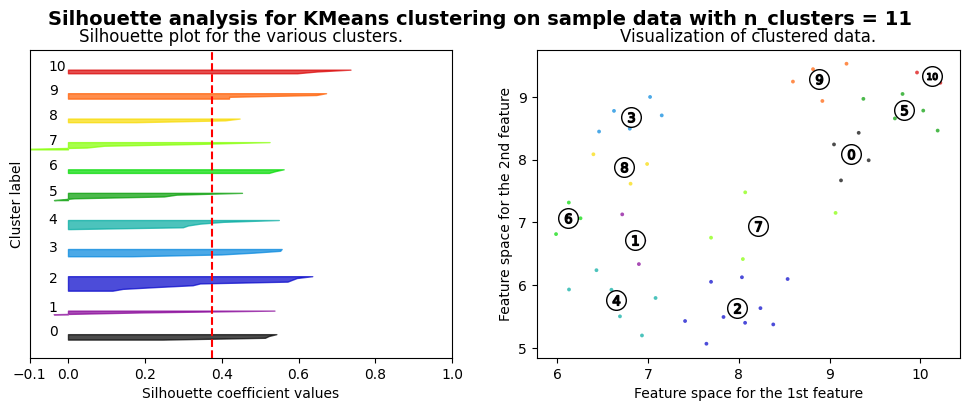

For n_clusters = 12, the average silhouette score is: 0.35
For n_clusters = 12, the Calinski-Harabasz index is: 86.52
For n_clusters = 12, the Davies-Bouldin score is: 0.73


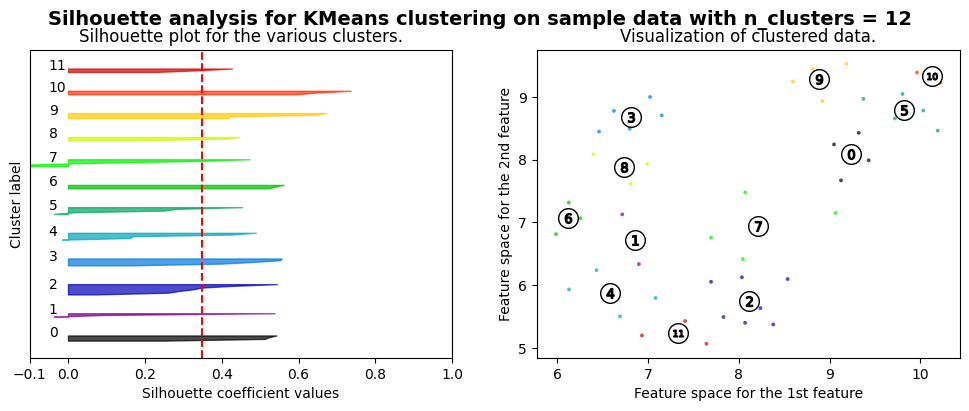

For n_clusters = 13, the average silhouette score is: 0.34
For n_clusters = 13, the Calinski-Harabasz index is: 81.69
For n_clusters = 13, the Davies-Bouldin score is: 0.70


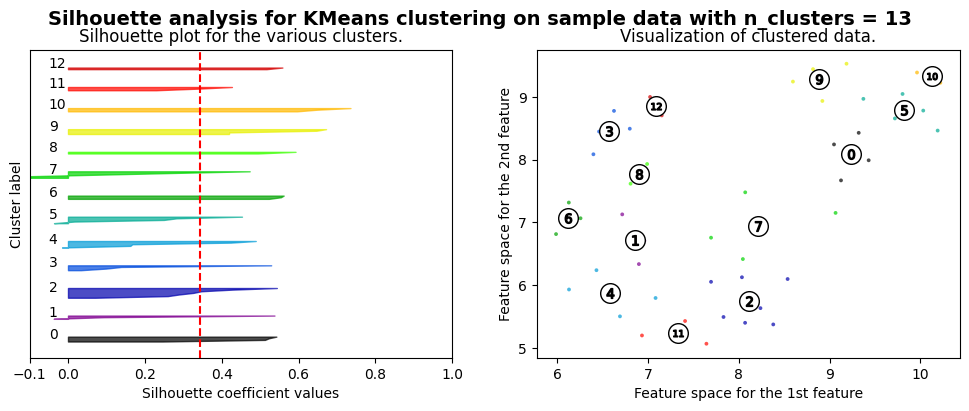

For n_clusters = 14, the average silhouette score is: 0.35
For n_clusters = 14, the Calinski-Harabasz index is: 88.54
For n_clusters = 14, the Davies-Bouldin score is: 0.69


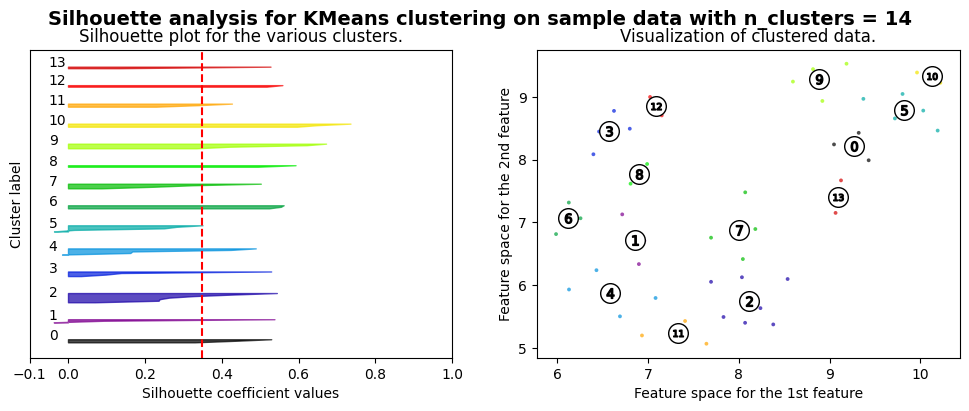

For n_clusters = 15, the average silhouette score is: 0.34
For n_clusters = 15, the Calinski-Harabasz index is: 89.78
For n_clusters = 15, the Davies-Bouldin score is: 0.69


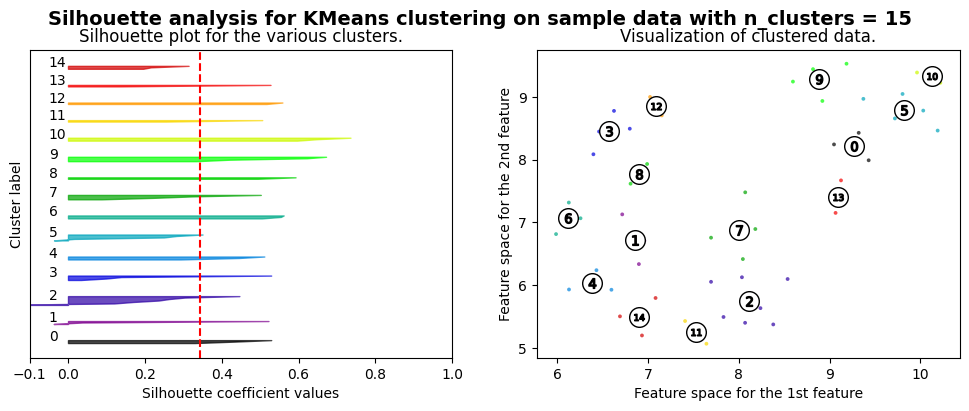

For n_clusters = 16, the average silhouette score is: 0.36
For n_clusters = 16, the Calinski-Harabasz index is: 99.97
For n_clusters = 16, the Davies-Bouldin score is: 0.69


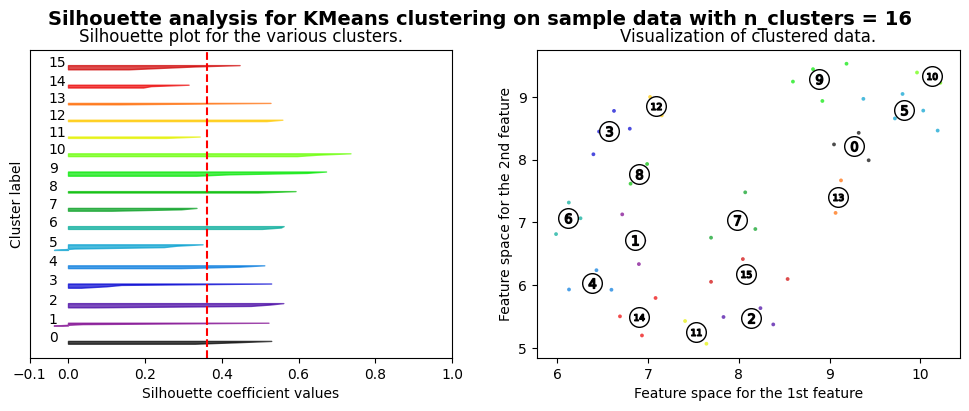

For n_clusters = 17, the average silhouette score is: 0.35
For n_clusters = 17, the Calinski-Harabasz index is: 98.54
For n_clusters = 17, the Davies-Bouldin score is: 0.68


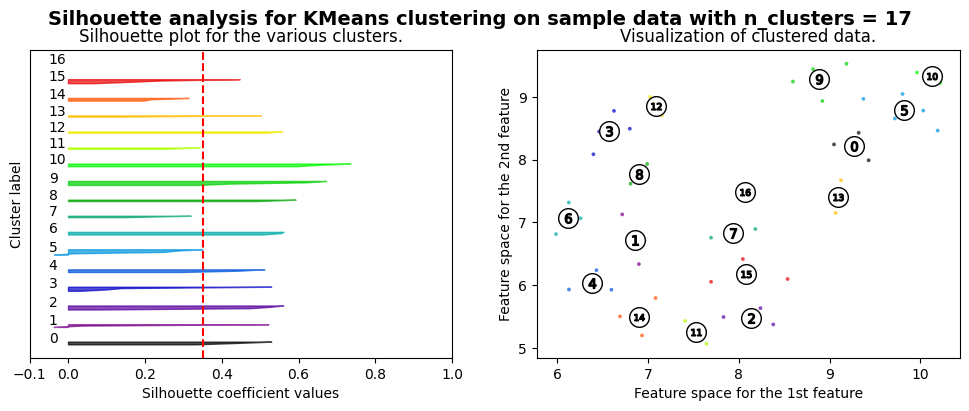

For n_clusters = 18, the average silhouette score is: 0.33
For n_clusters = 18, the Calinski-Harabasz index is: 94.09
For n_clusters = 18, the Davies-Bouldin score is: 0.67


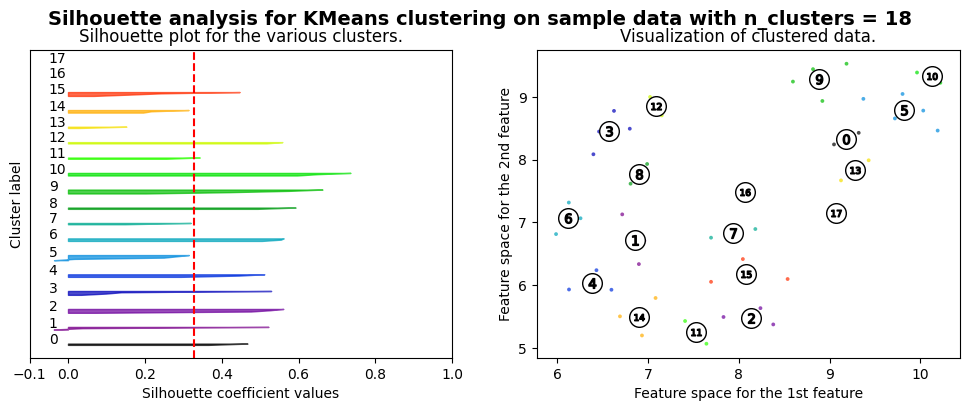

For n_clusters = 19, the average silhouette score is: 0.32
For n_clusters = 19, the Calinski-Harabasz index is: 96.29
For n_clusters = 19, the Davies-Bouldin score is: 0.69


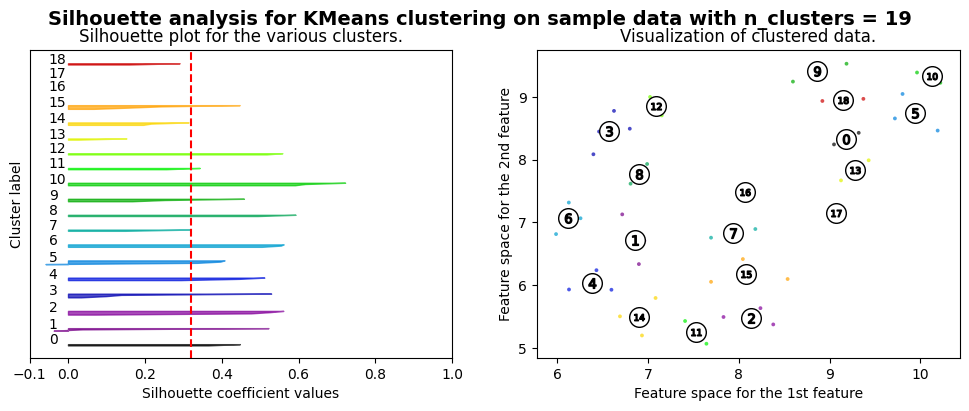

For n_clusters = 20, the average silhouette score is: 0.30
For n_clusters = 20, the Calinski-Harabasz index is: 94.84
For n_clusters = 20, the Davies-Bouldin score is: 0.67


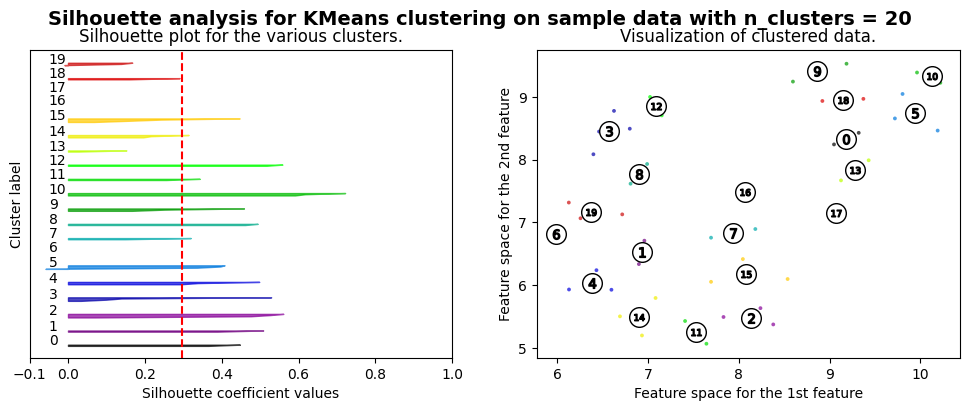

In [33]:
# Range of cluster numbers (K) to evaluate
range_n_clusters = [2, 3, 4, 5, 6, 7, 8,9,10,11,12,13,14,15,16,17,18,19,20]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_umap) + (n_clusters + 1) * 10])

    # Initialize the KMeans object and fit it to the data
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(X_umap)

    # Compute the silhouette score for the current clustering
    silhouette_avg = silhouette_score(X_umap, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is: {silhouette_avg:.2f}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_umap, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("Silhouette plot for the various clusters.")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_umap[:, 0], X_umap[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = kmeans.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("Visualization of clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    # Compute and print the Calinski-Harabasz index and Davies-Bouldin score
    calinski_harabasz = calinski_harabasz_score(X_umap, cluster_labels)
    davies_bouldin = davies_bouldin_score(X_umap, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the Calinski-Harabasz index is: {calinski_harabasz:.2f}")
    print(f"For n_clusters = {n_clusters}, the Davies-Bouldin score is: {davies_bouldin:.2f}")

    plt.show()

In [34]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
cluster_labels_umap = kmeans.fit_predict(X_umap)

In [35]:
umap_df= demographics.copy()

In [36]:
umap_df['Cluster'] = cluster_labels_umap

In [37]:
# umap_df.to_excel('../datasets/umap-dem-clusters.xlsx', index=False)